In [39]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# Get the data as a pandas dataframe
data = fetch_openml('adult', version=2, as_frame=True)

X = data.data
y = data.target

# Sanity check
print(X.head())
print(y.value_counts())

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country  
0              

class
<=50K    37155
>50K     11687
Name: count, dtype: int64


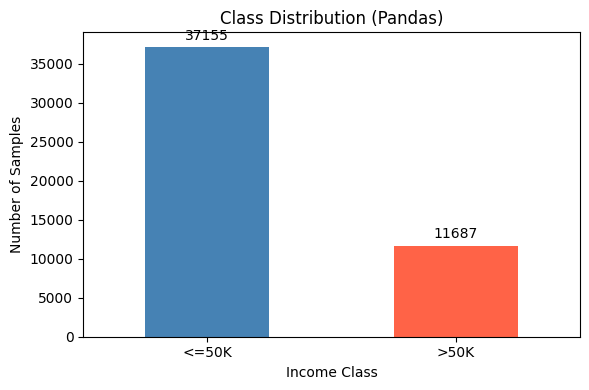

In [24]:
# Exploratory Data Analysis
class_counts = y.value_counts().sort_index()
print(class_counts)

ax = class_counts.plot.bar(
    figsize=(6, 4),
    color=["steelblue", "tomato"],
    rot=0,                     
    legend=False
)

ax.set_xlabel("Income Class")
ax.set_ylabel("Number of Samples")
ax.set_title("Class Distribution (Pandas)")
ax.bar_label(ax.containers[0], fmt='%d', padding=3) 

plt.tight_layout()
plt.show()

In [25]:
# Identify column types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

print("Numeric columns:", numeric_features)
print("Categorical columns:", categorical_features)

# Preprocessing - one-hot encode categoricals, scale numerics
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Baseline model - Logistic Regression
baseline_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ]
)

# Split the data, 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Train the baseline model
baseline_model.fit(X_train, y_train)

Numeric columns: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Categorical columns: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
# Test the model
y_pred = baseline_model.predict(X_test)

Baseline Logistic Regression Accuracy: 0.8543
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      7431
        >50K       0.74      0.60      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769



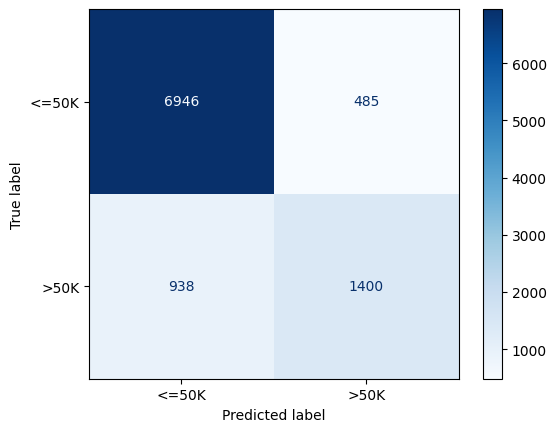

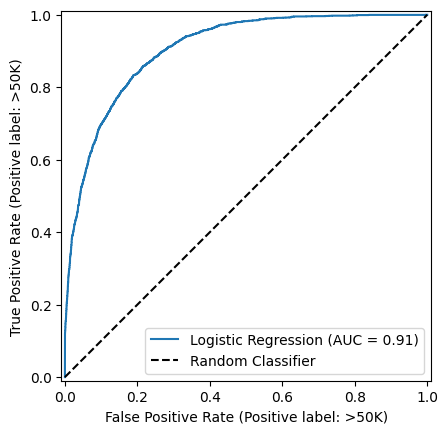

In [27]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Baseline Logistic Regression Accuracy: {acc:.4f}")

# Detailed metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()

# ROC
RocCurveDisplay.from_estimator(
    baseline_model,
    X_test,
    y_test,
    name="Logistic Regression"
)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Diagonal reference line
plt.legend()
plt.show()

In [28]:
# Training Support Vector Machine
svm_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(kernel="linear", C=1))
    ]
)

svm_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Baseline Support Vector Machine Accuracy: 0.8535
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7431
        >50K       0.75      0.58      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769



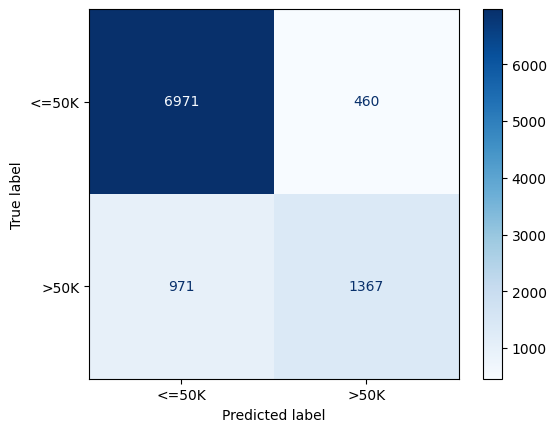

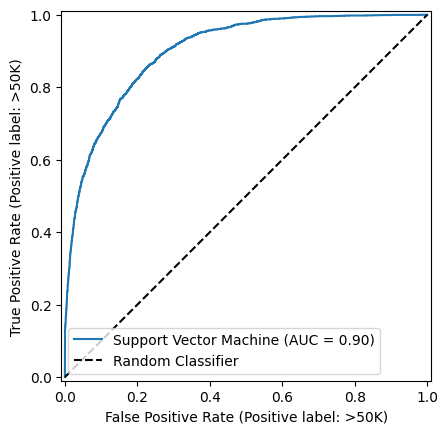

In [32]:
# Testing the model and gathering metrics
y_pred = svm_model.predict(X_test)

# Accuracy
svm_acc = accuracy_score(y_test, y_pred)
print(f"Baseline Support Vector Machine Accuracy: {svm_acc:.4f}")

# Detailed metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()

# ROC
RocCurveDisplay.from_estimator(
    svm_model,
    X_test,
    y_test,
    name="Support Vector Machine"
)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.show()

In [34]:
# Training Decision Tree
decision_tree = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=50,
            min_samples_leaf=20,
            max_features='sqrt',
            criterion='gini',
            class_weight='balanced',
            random_state=42
            )
        )
    ]
)

decision_tree.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Decision Tree Accuracy: 0.7516
              precision    recall  f1-score   support

       <=50K       0.94      0.72      0.81      7431
        >50K       0.49      0.86      0.62      2338

    accuracy                           0.75      9769
   macro avg       0.72      0.79      0.72      9769
weighted avg       0.83      0.75      0.77      9769



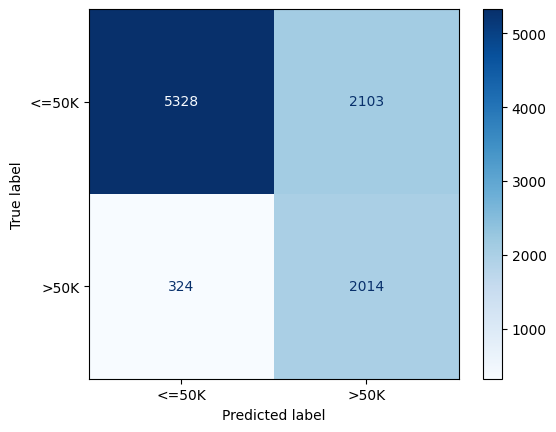

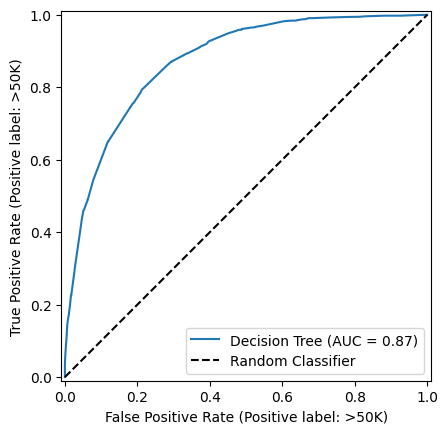

In [35]:
# Testing the decision tree and gathering metrics
y_pred = decision_tree.predict(X_test)

# Accuracy
dt_acc = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {dt_acc:.4f}")

# Detailed metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()

# ROC
RocCurveDisplay.from_estimator(
  decision_tree,
  X_test,
  y_test,
  name="Decision Tree"
)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.show()

In [37]:
# Training K Nearest Neighbors
k_nearest = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(
            n_neighbors=5,
            weights='distance',
            algorithm='auto',
            metric='minkowski',
            p=2,
            n_jobs=-1
            )
        )
    ]
)

k_nearest.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


KNN Accuracy: 0.8310
              precision    recall  f1-score   support

       <=50K       0.88      0.90      0.89      7431
        >50K       0.66      0.60      0.63      2338

    accuracy                           0.83      9769
   macro avg       0.77      0.75      0.76      9769
weighted avg       0.83      0.83      0.83      9769



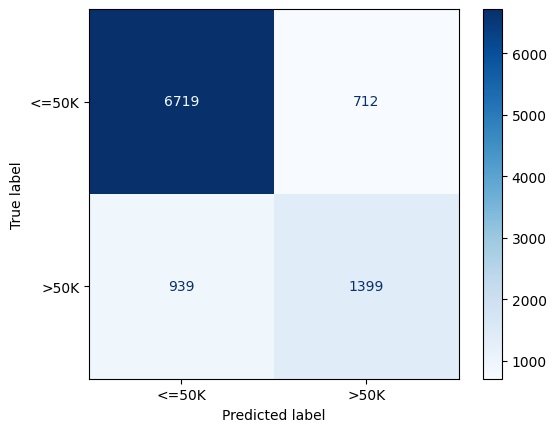

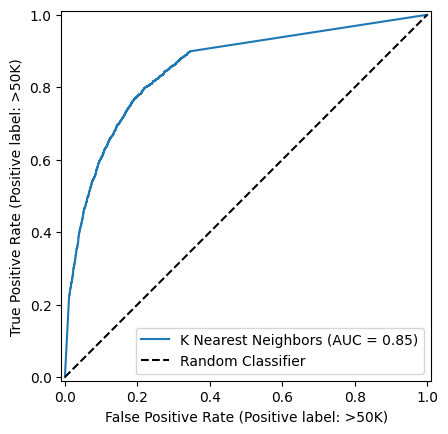

In [44]:
# Testing the KNN and gathering metrics
y_pred = k_nearest.predict(X_test)

# Accuracy
k_acc = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {k_acc:.4f}")

# Detailed metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()

# ROC
RocCurveDisplay.from_estimator(
  k_nearest,
  X_test,
  y_test,
  name="K Nearest Neighbors"
)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.show()

In [42]:
# Training Perceptron
perceptron = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SGDClassifier(
            loss="perceptron", 
            learning_rate="constant",
            eta0=0.01
            )
        )
    ]
)

perceptron.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Perceptron Accuracy: 0.8124
              precision    recall  f1-score   support

       <=50K       0.86      0.90      0.88      7431
        >50K       0.63      0.54      0.58      2338

    accuracy                           0.81      9769
   macro avg       0.74      0.72      0.73      9769
weighted avg       0.80      0.81      0.81      9769



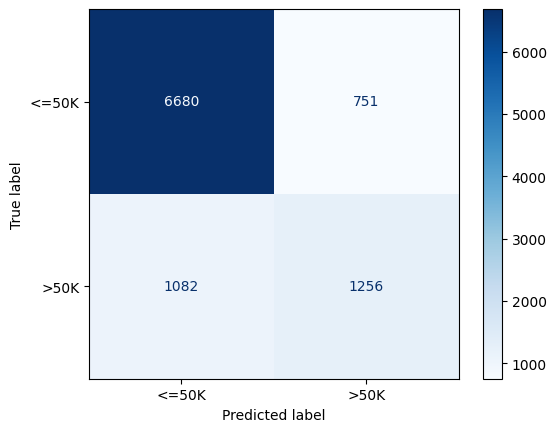

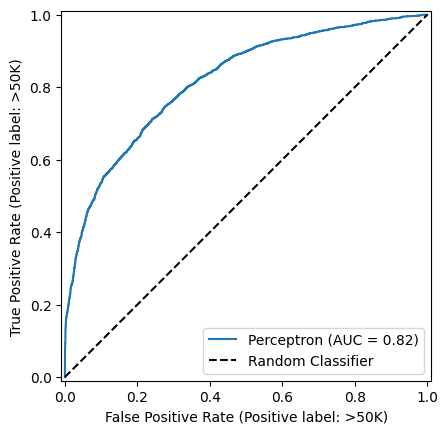

In [45]:
# Testing the perception and gathering metrics
y_pred = perceptron.predict(X_test)

# Accuracy
p_acc = accuracy_score(y_test, y_pred)
print(f"Perceptron Accuracy: {p_acc:.4f}")

# Detailed metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()

# ROC
RocCurveDisplay.from_estimator(
  perceptron,
  X_test,
  y_test,
  name="Perceptron"
)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.show()